Change Log:
- v19 - use parameters from model-19-build, lower learning rate = 0.0005
- v20 - lower learning rate = 0.0008, add height_r and top_floor index
- v16 - change parameters (some from model 05), rm reduce to 68
- v14 - change random seed
- v10 - remove features based on feature importance results (exp-l04-per-area)

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
model_name = 'model-25-lgb-search-bins-lr-0.0005-250'

### Params

In [3]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'height_r', 'top_floor']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)

In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
display(train.head(5))
display(test.head(5))

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.4622312795739
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.81980868401074
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.8005430183116
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906168328487
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.21309507601745


### Preprocessing

In [9]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [11]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Params

In [12]:
# params
# parameters from model 10: 24, 300, 0.5, 10, 0.1, 0.0
# parameters from model 5: 24, 258, 0.4, 6, 0.04, 0.02
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.0005, # 0.001
          'max_depth': 26,
          'num_leaves': 250,  # 300        # may reduce in dim-reduction exp
          'feature_fraction': 0.45,
          'min_data_in_leaf': 5,
          'lambda_l1': 0.05,
          'lambda_l2': 0.001,
          'max_bin': 383,
          'min_sum_hessian_in_leaf': 0.0001,
          'seed': 555,
         }

lgb_other_params = {'num_boost_round': 1000000,  # expected to stop 250000
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,}


### kfold cross-predict

In [13]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params, keep_training_booster=True)
    best_iterations.append(model.best_iteration)

    # Predict on val set
    y_pred = model.predict(df_val[cols_feats])
    mse = mean_squared_error(df_val[col_target], y_pred)
    mae = mean_absolute_error(df_val[col_target], y_pred)
    mape = cal_mape(df_val[col_target], y_pred)
    
    y_pred_final = post_processing(y_pred, df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

    # Predict on test set
    y_pred_test = model.predict(df_test[cols_feats])
    predicts_test['target_{}'.format(i)] = y_pred_test

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0265637
[4000]	valid_0's mape: 0.015858
[6000]	valid_0's mape: 0.0126494
[8000]	valid_0's mape: 0.0114994
[10000]	valid_0's mape: 0.0109351
[12000]	valid_0's mape: 0.010589
[14000]	valid_0's mape: 0.0103503
[16000]	valid_0's mape: 0.0101749
[18000]	valid_0's mape: 0.0100397
[20000]	valid_0's mape: 0.00992904
[22000]	valid_0's mape: 0.00983702
[24000]	valid_0's mape: 0.00975966
[26000]	valid_0's mape: 0.00969418
[28000]	valid_0's mape: 0.00963908
[30000]	valid_0's mape: 0.00959184
[32000]	valid_0's mape: 0.00955023
[34000]	valid_0's mape: 0.00951474
[36000]	valid_0's mape: 0.00948257
[38000]	valid_0's mape: 0.00945341
[40000]	valid_0's mape: 0.00942716
[42000]	valid_0's mape: 0.00940343
[44000]	valid_0's mape: 0.00938162
[46000]	valid_0's mape: 0.00936098
[48000]	valid_0's mape: 0.00934249
[50000]	valid_0's mape: 0.00932509
[52000]	valid_0's mape: 0.00930876
[54000]	valid_0's mape: 0.00929317
[56000

[2000]	valid_0's mape: 0.026704
[4000]	valid_0's mape: 0.016029
[6000]	valid_0's mape: 0.0128059
[8000]	valid_0's mape: 0.0116464
[10000]	valid_0's mape: 0.0110796
[12000]	valid_0's mape: 0.0107343
[14000]	valid_0's mape: 0.0104982
[16000]	valid_0's mape: 0.0103271
[18000]	valid_0's mape: 0.0101937
[20000]	valid_0's mape: 0.0100826
[22000]	valid_0's mape: 0.00998954
[24000]	valid_0's mape: 0.00991076
[26000]	valid_0's mape: 0.00984303
[28000]	valid_0's mape: 0.00978571
[30000]	valid_0's mape: 0.00973754
[32000]	valid_0's mape: 0.00969577
[34000]	valid_0's mape: 0.00965817
[36000]	valid_0's mape: 0.00962539
[38000]	valid_0's mape: 0.00959544
[40000]	valid_0's mape: 0.00956798
[42000]	valid_0's mape: 0.00954352
[44000]	valid_0's mape: 0.00952081
[46000]	valid_0's mape: 0.00949947
[48000]	valid_0's mape: 0.0094796
[50000]	valid_0's mape: 0.00946134
[52000]	valid_0's mape: 0.00944448
[54000]	valid_0's mape: 0.00942869
[56000]	valid_0's mape: 0.00941387
[58000]	valid_0's mape: 0.00939971
[6

[462000]	valid_0's mape: 0.0091132
Early stopping, best iteration is:
[462090]	valid_0's mape: 0.0091132
(Fold 1) score, mse, mae, mape: 5964.87450, 0.03842, 0.12138, 0.00911.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0263948
[4000]	valid_0's mape: 0.0157638
[6000]	valid_0's mape: 0.012611
[8000]	valid_0's mape: 0.0114978
[10000]	valid_0's mape: 0.0109563
[12000]	valid_0's mape: 0.0106313
[14000]	valid_0's mape: 0.0104107
[16000]	valid_0's mape: 0.010247
[18000]	valid_0's mape: 0.0101214
[20000]	valid_0's mape: 0.0100184
[22000]	valid_0's mape: 0.0099294
[24000]	valid_0's mape: 0.00985594
[26000]	valid_0's mape: 0.00979372
[28000]	valid_0's mape: 0.00973994
[30000]	valid_0's mape: 0.00969459
[32000]	valid_0's mape: 0.00965578
[34000]	valid_0's mape: 0.00962158
[36000]	valid_0's mape: 0.00959061
[38000]	valid_0's mape: 0.0095622
[40000]	valid_0's mape: 0.00953665
[42000]	valid_0's mape: 0.00951365
[44000]	valid_0's mape: 0.00949195
[46000]	

[450000]	valid_0's mape: 0.00910945
[452000]	valid_0's mape: 0.0091094
[454000]	valid_0's mape: 0.00910937
[456000]	valid_0's mape: 0.00910934
[458000]	valid_0's mape: 0.0091093
Early stopping, best iteration is:
[458752]	valid_0's mape: 0.00910929
(Fold 2) score, mse, mae, mape: 5955.87216, 0.03789, 0.12113, 0.00911.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0265795
[4000]	valid_0's mape: 0.0158272
[6000]	valid_0's mape: 0.0126887
[8000]	valid_0's mape: 0.0116126
[10000]	valid_0's mape: 0.0110926
[12000]	valid_0's mape: 0.0107692
[14000]	valid_0's mape: 0.0105479
[16000]	valid_0's mape: 0.0103851
[18000]	valid_0's mape: 0.0102557
[20000]	valid_0's mape: 0.0101497
[22000]	valid_0's mape: 0.0100562
[24000]	valid_0's mape: 0.00997853
[26000]	valid_0's mape: 0.0099117
[28000]	valid_0's mape: 0.00985561
[30000]	valid_0's mape: 0.0098069
[32000]	valid_0's mape: 0.00976428
[34000]	valid_0's mape: 0.00972647
[36000]	valid_0's mape: 0.00969303
[38

[450000]	valid_0's mape: 0.00914214
[452000]	valid_0's mape: 0.00914208
[454000]	valid_0's mape: 0.00914201
[456000]	valid_0's mape: 0.00914198
[458000]	valid_0's mape: 0.00914193
Early stopping, best iteration is:
[458798]	valid_0's mape: 0.00914191
(Fold 3) score, mse, mae, mape: 5881.87490, 0.03697, 0.12171, 0.00914.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.026897
[4000]	valid_0's mape: 0.0160715
[6000]	valid_0's mape: 0.0127665
[8000]	valid_0's mape: 0.0115721
[10000]	valid_0's mape: 0.0109853
[12000]	valid_0's mape: 0.0106414
[14000]	valid_0's mape: 0.0104103
[16000]	valid_0's mape: 0.0102375
[18000]	valid_0's mape: 0.0101057
[20000]	valid_0's mape: 0.00999717
[22000]	valid_0's mape: 0.00990521
[24000]	valid_0's mape: 0.00982798
[26000]	valid_0's mape: 0.00976339
[28000]	valid_0's mape: 0.00970867
[30000]	valid_0's mape: 0.00966147
[32000]	valid_0's mape: 0.00961971
[34000]	valid_0's mape: 0.00958336
[36000]	valid_0's mape: 0.0095504

[442000]	valid_0's mape: 0.00905892
[444000]	valid_0's mape: 0.00905888
[446000]	valid_0's mape: 0.00905886
[448000]	valid_0's mape: 0.00905882
[450000]	valid_0's mape: 0.00905879
[452000]	valid_0's mape: 0.00905875
[454000]	valid_0's mape: 0.00905874
[456000]	valid_0's mape: 0.00905872
[458000]	valid_0's mape: 0.00905871
Early stopping, best iteration is:
[457589]	valid_0's mape: 0.0090587
(Fold 4) score, mse, mae, mape: 5891.87286, 0.03687, 0.12051, 0.00906.


In [14]:
print('Total run time:', time.time() - t0)

Total run time: 69604.83816576004


In [15]:
print('Kfold cv score (mean, stdev, all):', np.mean(scores), np.std(scores), scores) # 5868.87314

Kfold cv score (mean, stdev, all): 5908.874237664586 44.37013677216624 [5849.876775056154, 5964.874497845826, 5955.872155525032, 5881.87489561274, 5891.872864283182]


In [16]:
mapes = np.mod(scores, 1)
print('Kfold cv mape (mean, stdev, all):', np.mean(mapes), np.std(mapes), mapes)

Kfold cv mape (mean, stdev, all): 0.8742376645868717 0.0016223703412978074 [0.87677506 0.87449785 0.87215553 0.87489561 0.87286428]


In [17]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.151090,15.198807,15.263310,15.208742,15.134891
1,BTshNOJyKHnT2YIT,13.135424,13.120902,13.136580,13.144478,13.139785
2,dhdymr0lV8N5kZOT,13.647283,13.678725,13.696139,13.674343,13.685386
3,VEwyGGMcD56w5BOc,14.806717,14.790474,14.763363,14.802120,14.777621
4,wmUeMoJZfsqaSX9b,12.144680,12.137670,12.081708,12.173861,12.201740


In [18]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [19]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [445869, 462090, 458752, 458798, 457589]
Mean best iterations: 456619


### One-fold test

In [20]:
lgb_other_params_one = {'num_boost_round': int(np.mean(best_iterations)*1.2),
                        'verbose_eval': 2000,}
lgb_other_params_one

{'num_boost_round': 547943, 'verbose_eval': 2000}

In [21]:
params

{'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'mse',
 'metric': 'mape',
 'learning_rate': 0.0005,
 'max_depth': 26,
 'num_leaves': 250,
 'feature_fraction': 0.45,
 'min_data_in_leaf': 5,
 'lambda_l1': 0.05,
 'lambda_l2': 0.001,
 'max_bin': 383,
 'min_sum_hessian_in_leaf': 0.0001,
 'seed': 555}

In [22]:
t10 = time.time()

df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

# Construct lgb dataset
lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()

# train model    
model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_one, keep_training_booster=True)

y_pred = model.predict(df_test[cols_feats])
y_pred_final = post_processing(y_pred, df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})

t11 = time.time()

display(df_test_pred.head(20))

[2000]	training's mape: 0.0260922
[4000]	training's mape: 0.0147424
[6000]	training's mape: 0.0110101
[8000]	training's mape: 0.00945809
[10000]	training's mape: 0.00855756
[12000]	training's mape: 0.00791603
[14000]	training's mape: 0.0074146
[16000]	training's mape: 0.00700012
[18000]	training's mape: 0.00664562
[20000]	training's mape: 0.00633203
[22000]	training's mape: 0.00604721
[24000]	training's mape: 0.00579322
[26000]	training's mape: 0.00556487
[28000]	training's mape: 0.00535825
[30000]	training's mape: 0.00517014
[32000]	training's mape: 0.00499762
[34000]	training's mape: 0.00483831
[36000]	training's mape: 0.00468922
[38000]	training's mape: 0.00454798
[40000]	training's mape: 0.0044151
[42000]	training's mape: 0.00428852
[44000]	training's mape: 0.00416811
[46000]	training's mape: 0.00405347
[48000]	training's mape: 0.00394491
[50000]	training's mape: 0.00384162
[52000]	training's mape: 0.00374244
[54000]	training's mape: 0.00364624
[56000]	training's mape: 0.00355305
[

[446000]	training's mape: 0.000240938
[448000]	training's mape: 0.000239059
[450000]	training's mape: 0.000237303
[452000]	training's mape: 0.000235558
[454000]	training's mape: 0.000233862
[456000]	training's mape: 0.00023215
[458000]	training's mape: 0.000230402
[460000]	training's mape: 0.000228645
[462000]	training's mape: 0.000226983
[464000]	training's mape: 0.000225377
[466000]	training's mape: 0.000223766
[468000]	training's mape: 0.000222133
[470000]	training's mape: 0.000220587
[472000]	training's mape: 0.000219065
[474000]	training's mape: 0.000217521
[476000]	training's mape: 0.000216019
[478000]	training's mape: 0.000214541
[480000]	training's mape: 0.000213038
[482000]	training's mape: 0.000211549
[484000]	training's mape: 0.000210081
[486000]	training's mape: 0.000208653
[488000]	training's mape: 0.00020729
[490000]	training's mape: 0.000205888
[492000]	training's mape: 0.000204496
[494000]	training's mape: 0.000203126
[496000]	training's mape: 0.000201853
[498000]	train

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.456214e+07
1,BTshNOJyKHnT2YIT,3.903389e+06
2,dhdymr0lV8N5kZOT,1.064055e+07
3,VEwyGGMcD56w5BOc,6.006309e+06
4,wmUeMoJZfsqaSX9b,1.091787e+06
5,EtBjGAHmHCe9t7TZ,2.678200e+06
6,hPNH34vmaZtvBtqc,1.218763e+07
7,wXjeI38bYDMJJwZC,6.266121e+06
8,fxZSGX6aPAFKU8W4,1.677495e+06
9,ewr0Fx6ign87OwaV,4.093801e+06


In [23]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [24]:
print('Total run time:', t11 - t10)

Total run time: 16309.43706870079


### Feature importance

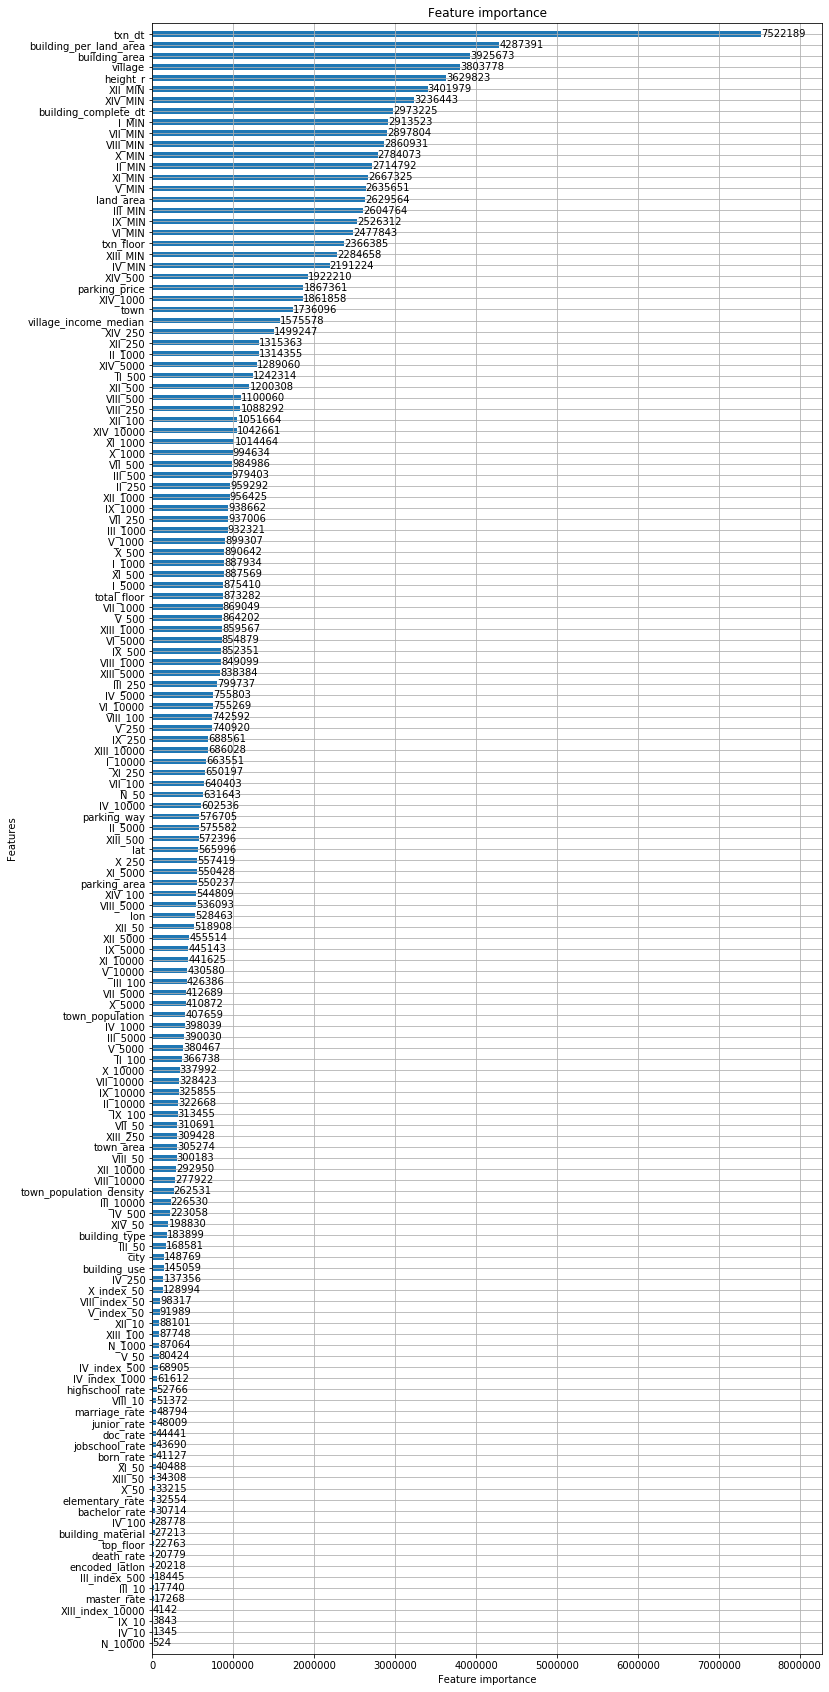

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

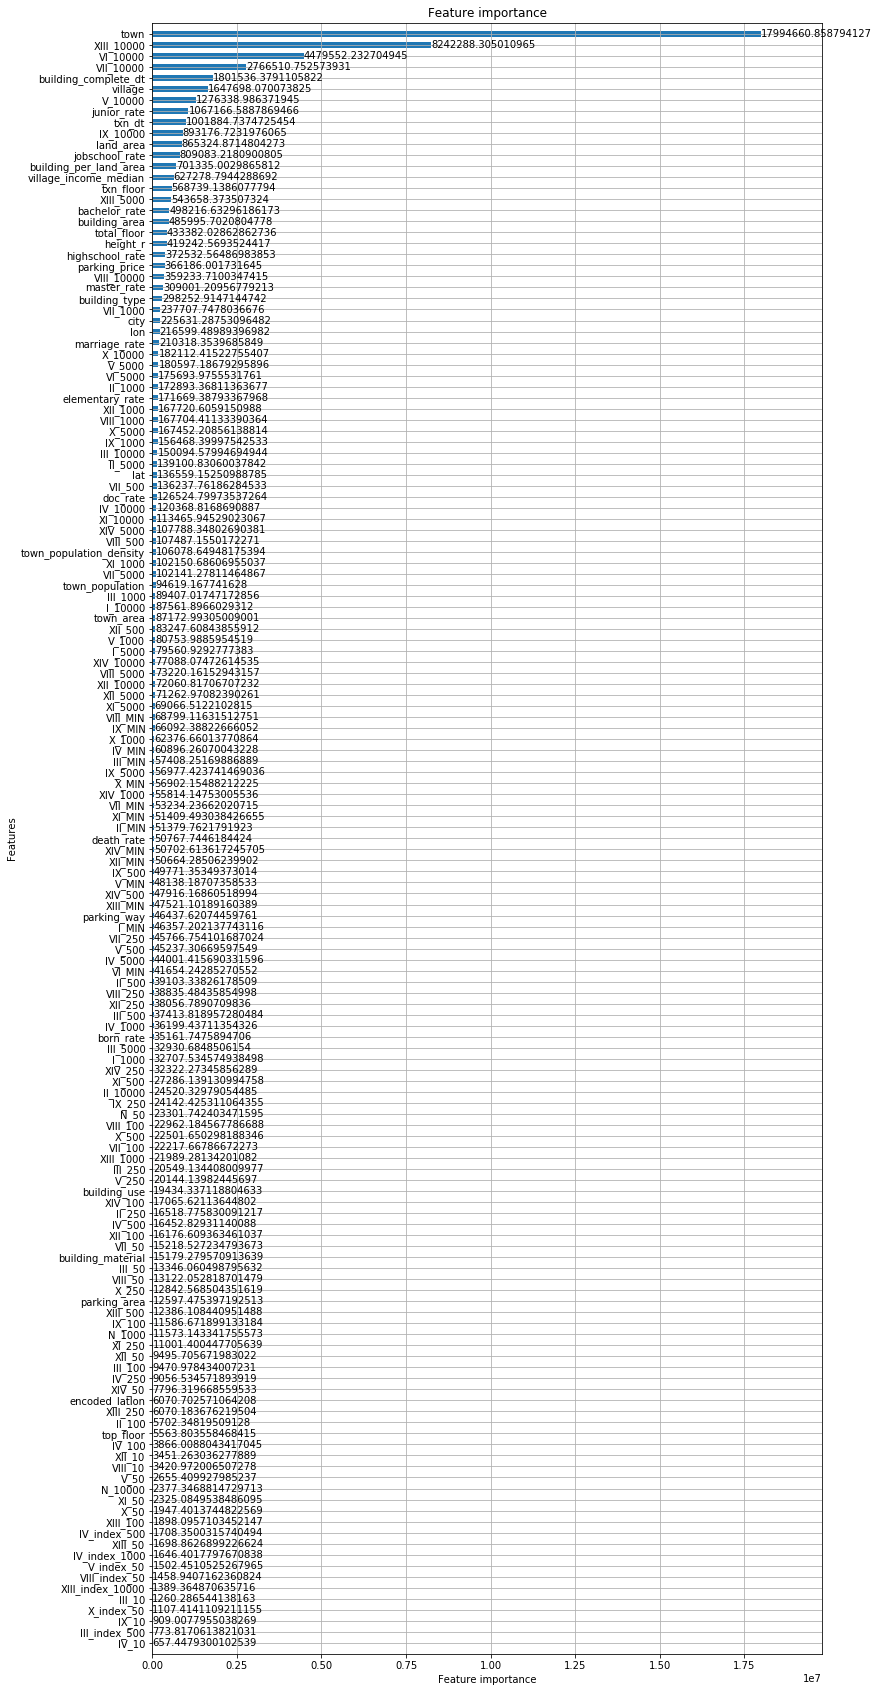

In [26]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()